# Game Theory Simulator  
### Prisoner's Dilemma, Matching Pennies, Battle of the Sexes, and Repeated Games

This project simulates classic game theory scenarios using Python.  
We will build payoff matrices, strategies, repeated games, and tournaments.


In [169]:
import numpy as np
import random
import pandas as pd


## 1. Defining Payoff Matrices

We start by defining the payoff matrices for:
- Prisoner's Dilemma
- Matching Pennies
- Battle of the Sexes


In [170]:
# Prisoner's Dilemma (years of prison)
PD = {
    ("C", "C"): (1, 1),   # both cooperate → 1 year each
    ("C", "D"): (3, 0),   # P1 cooperates, P2 defects → P1: 3 years, P2: 0
    ("D", "C"): (0, 3),   # P1 defects, P2 cooperates → P1: 0 years, P2: 3
    ("D", "D"): (2, 2)    # both defect → 2 years each
}
# C--> cooperate,  means both remain quite
# D--> defect, means betray the other prisoner by giving evidence again him/her
# This creates a dilemma:  
# Each prisoner individually prefers to defect, 
# but mutual defection leads to a worse outcome than mutual cooperation.
# Single Nash equlibrium possible


# Matching Pennies 
MP = {
    ("H", "H"): (1, -1),
    ("H", "T"): (-1, 1),
    ("T", "H"): (-1, 1),
    ("T", "T"): (1, -1)
}
# This is a zero sum game/ pure conflict
# We solve using mixed startegies as there is no pure Nash-equilibrium


# Battle of the Sexes 
BoS = {
    ("O", "O"): (2, 1),
    ("O", "F"): (0, 0),
    ("F", "O"): (0, 0),
    ("F", "F"): (1, 2)
}
#This is about coordination and conflict of interest
#Two Nash equilibria possible so we go to mixed strategies

## 2. Helper Function

This function takes a game (payoff matrix) and the actions chosen by both players, and returns the corresponding payoff.
It works for all games: Prisoner's Dilemma, Matching Pennies, and Battle of the Sexes.


In [171]:
def get_payoff(game, action_A, action_B):
    return game[(action_A, action_B)]


## 3. Basic Strategies

These strategies always choose the same action, regardless of history.
They help us test the simulator before adding smarter strategies.


In [172]:
## Strategies for Prisoner's Dilemma
def always_cooperate(history_self, history_opp):
    return "C"
def always_defect(history_self, history_opp):
    return "D"


## strategies for matching pennies
import random
def random_HT(history_self, history_opp):
    return "H" if random.random() < 0.5 else "T"
def bias_heads(history_self, history_opp):
    return "H" if random.random() < 0.7 else "T"
def bias_tails(history_self, history_opp):
    return "T" if random.random() < 0.7 else "H"

## startegies for battle of sexes
def prefer_opera(history_self, history_opp):
    return "O"
def prefer_football(history_self, history_opp):
    return "F"
def alternate_OF(history_self, history_opp):
    return "O" if len(hs)%2==0 else "F"


## 4. One‑Shot Game Simulation

This function simulates a single round of a game.
Each player chooses an action, and we look up the payoff from the payoff matrix.


In [173]:
def play_one_shot(game, strategy_A, strategy_B):
    history_A, history_B = [], []
    action_A = strategy_A(history_A, history_B)
    action_B = strategy_B(history_B, history_A)
    payoff_A, payoff_B = get_payoff(game, action_A, action_B)
    return action_A, action_B, payoff_A, payoff_B

#run one-shot simulation for prisoner's dilemma
print(play_one_shot(PD, always_cooperate, always_defect))
print(play_one_shot(MP, random_HT, random_HT))
print(play_one_shot(BoS, prefer_opera, prefer_football))

('C', 'D', 3, 0)
('H', 'T', -1, 1)
('O', 'F', 0, 0)


## 5. Repeated Games

Players interact for many rounds.  
Prison years, Scores for mathcing pennies, happiness level in battle of sexes accumulate across rounds.
Strategies can react to past behavior.


In [174]:
## rounds use previous history
def play_repeated(game, strategy_A, strategy_B, rounds=10):
    history_A, history_B = [], []
    total_A = total_B = 0

    for _ in range(rounds):
        action_A = strategy_A(history_A, history_B)
        action_B = strategy_B(history_B, history_A)
        payoff_A, payoff_B = get_payoff(game, action_A, action_B)

        total_A += payoff_A
        total_B += payoff_B

        history_A.append(action_A)
        history_B.append(action_B)

    ## we get total prison years, total score, total level
    return history_A, history_B, total_A, total_B


## 6. History‑Based Strategies

These strategies react to the opponent's past actions.


In [175]:
## copies opponent's last move
def tit_for_tat(history_self, history_opp):
    if len(history_opp) == 0:
        return "C"
    return history_opp[-1]

## one betrayel, so defect forever
def grim_trigger(history_self, history_opp):
    if "D" in history_opp:
        return "D"
    return "C"


In [176]:
## test simulation for repeated rounds
print("For matching Pennies")
print(play_repeated(MP,random_HT, random_HT,rounds=10))
print("For prisoner's dilemma")
print(play_repeated(PD, tit_for_tat, always_defect, rounds=5))


For matching Pennies
(['H', 'T', 'T', 'T', 'H', 'T', 'T', 'H', 'H', 'T'], ['H', 'T', 'H', 'H', 'H', 'H', 'T', 'H', 'T', 'T'], 2, -2)
For prisoner's dilemma
(['C', 'D', 'D', 'D', 'D'], ['D', 'D', 'D', 'D', 'D'], 11, 8)


## 7. Tournament Between Strategies (for Prisoner's dilemma)

Each strategy plays every other strategy for several rounds.
We compare total prison years to see which strategy performs best.


In [177]:
import pandas as pd

strategies = [
    ("Always Cooperate", always_cooperate),
    ("Always Defect", always_defect),
    ("Tit For Tat", tit_for_tat),
    ("Grim Trigger", grim_trigger)
]

def tournament(game, strategies, rounds=10):
    results = []
    for name_A, strat_A in strategies:
        for name_B, strat_B in strategies:
            _, _, total_A, total_B = play_repeated(game, strat_A, strat_B, rounds)
            results.append((name_A, name_B, total_A, total_B))
    return pd.DataFrame(results, columns=["Player A", "Player B", "Years A", "Years B"])


In [178]:
tournament(PD, strategies, rounds=10)


,Player A,Player B,Years A,Years B
0,Always Cooperate,Always Cooperate,10,10
1,Always Cooperate,Always Defect,30,0
2,Always Cooperate,Tit For Tat,10,10
3,Always Cooperate,Grim Trigger,10,10
4,Always Defect,Always Cooperate,0,30
5,Always Defect,Always Defect,20,20
6,Always Defect,Tit For Tat,18,21
7,Always Defect,Grim Trigger,18,21
8,Tit For Tat,Always Cooperate,10,10
9,Tit For Tat,Always Defect,21,18


## 8. Summary of All Games

We summarize the key properties of each game.


In [179]:
import pandas as pd

summary = pd.DataFrame({
    "Game": ["Prisoner's Dilemma", "Matching Pennies", "Battle of the Sexes"],
    "Type": ["Dilemma", "Zero-Sum", "Coordination"],
    "Pure NE": ["(D,D)", "None", "(O,O), (F,F)"],
    "Mixed NE": ["None", "50-50", "p=2/3, q=1/3"]
})

summary


,Game,Type,Pure NE,Mixed NE
0,Prisoner's Dilemma,Dilemma,"(D,D)",None
1,Matching Pennies,Zero-Sum,None,50-50
2,Battle of the Sexes,Coordination,"(O,O), (F,F)","p=2/3, q=1/3"


# 9. Evolutionary Dynamics (Replicator Equation)

In evolutionary game theory, strategies behave like species in a population.
Strategies that perform well increase in frequency, while poorly performing strategies shrink.

We simulate this using the *replicator equation*:




x_i(t+1) = x_i(t) * pi_i/ pi_bar




Where:
- x_i = fraction of population using strategy i  
- pi_i = payoff of strategy i  
- pi_bar = average payoff of the population  

This allows us to see which strategies dominate over time.


In [180]:
import numpy as np

def evolutionary_dynamics(game, strategies, generations=60, rounds=20):
    n = len(strategies)
    freqs = np.ones(n) / n  # equal starting population
    history = [freqs.copy()]

    for _ in range(generations):
        payoffs = np.zeros(n)

        # expected fitness for each strategy against the population
        for i, (_, s1) in enumerate(strategies):
            total = 0.0
            for j, (_, s2) in enumerate(strategies):
                _, _, years_1, _ = play_repeated(game, s1, s2, rounds)
                fitness_1 = -years_1          # fewer years = higher fitness
                total += freqs[j] * fitness_1
            payoffs[i] = total

        avg_payoff = np.dot(freqs, payoffs)

        # avoid division issues
        if avg_payoff == 0:
            break

        # replicator update
        freqs = freqs * (payoffs / avg_payoff)
        freqs = freqs / freqs.sum()

        history.append(freqs.copy())

    return np.array(history)


## Evolution of Strategies in Prisoner's Dilemma


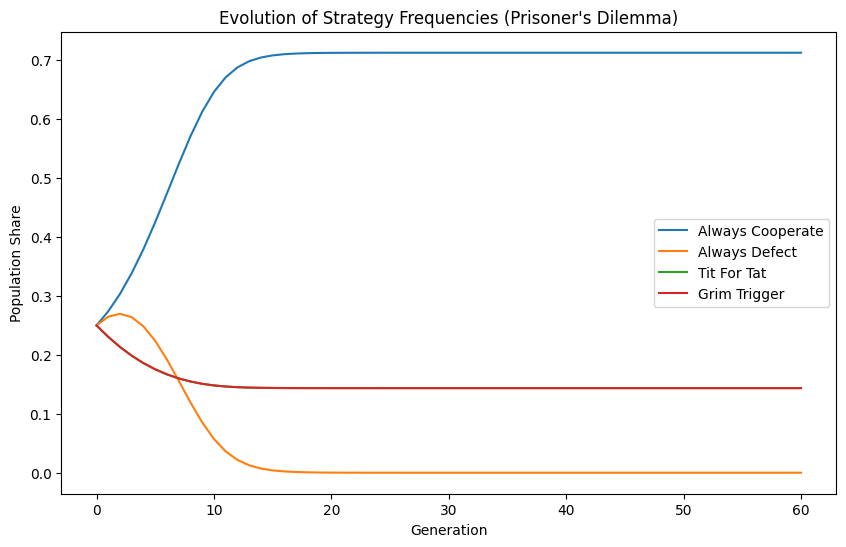

In [181]:
history_pd = evolutionary_dynamics(PD, strategies, generations=60, rounds=20)

plt.figure(figsize=(10,6))
for i, (name, _) in enumerate(strategies):
    plt.plot(history_pd[:, i], label=name)

plt.title("Evolution of Strategy Frequencies (Prisoner's Dilemma)")
plt.xlabel("Generation")
plt.ylabel("Population Share")
plt.legend()
plt.show()


## From the simulation, we observe that:

- Always Cooperate increases in frequency and becomes dominant.
- Always Defect declines and nearly disappears.
- Grim Trigger stabilizes at a moderate level.
- Tit For Tat remains at a low but non-zero share.


## 1.Why did Always Cooperate dominate?
Evolution rewards average payoff, not strategic safety.

## 2.Why does Always Defect disappear?
it exploits cooperators initially, gets punished by Grim/TFT, gets low payoff vs itself
As soon as punishers exist:
𝜋ALLD < 𝜋ˉ⇒ 𝑥ALLD ↓
Once its frequency drops, it cannot recover (absorbing state).

## 3.Why Grim Trigger stabilizes higher than TFT?
Grim:
    Harsh but simple
    Strong deterrence
TFT:
    Forgiving
    Suffers under noise or exploitation chains
In evolutionary terms:
    Grim has credible punishment, TFT has lenient punishment.



## Result/ conclusion
Under noiseless repeated interactions, strategies that maximize mutual cooperation achieve the highest evolutionary fitness. Always Cooperate dominates due to consistently high average payoffs once defectors are eliminated. However, this equilibrium is fragile and depends critically on the absence of noise and mutation.”